In [1]:
! git clone https://github.com/Mb-NextTime/early-med.git
! cd early-med && rm -r pycaret && rm -r TabEBM
! cd early-med && git clone https://github.com/Mb-NextTime/pycaret.git && git clone https://github.com/Mb-NextTime/TabEBM.git
! cd early-med && ./setup.sh
! cp early-med/src/utils.py .

Cloning into 'early-med'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 24 (delta 8), reused 24 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 6.40 MiB | 5.84 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Cloning into 'pycaret'...
remote: Enumerating objects: 30225, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 30225 (delta 252), reused 206 (delta 201), pack-reused 29911 (from 3)
Receiving objects: 100% (30225/30225), 256.03 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (22226/22226), done.
Updating files: 100% (319/319), done.
Cloning into 'TabEBM'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 123 (delta 66), reused 82 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (12

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from utils import *

In [2]:
full_data = openml.datasets.get_dataset(841).get_data()[0]
full_data.shape

(950, 10)

In [53]:
data, _ = train_test_split(full_data, train_size=200, random_state=1)

In [ ]:
profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 21 to 37
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   company1     200 non-null    float64 
 1   company2     200 non-null    float64 
 2   company3     200 non-null    float64 
 3   company4     200 non-null    float64 
 4   company5     200 non-null    float64 
 5   company6     200 non-null    float64 
 6   company7     200 non-null    float64 
 7   company8     200 non-null    float64 
 8   company9     200 non-null    float64 
 9   binaryClass  200 non-null    category
dtypes: category(1), float64(9)
memory usage: 15.9 KB


In [55]:
n_classes = data['binaryClass'].unique().size

---
### CatBoostEncoder

In [56]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='binaryClass',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,binaryClass
2,Target type,Binary
3,Target mapping,"N: 0, P: 1"
4,Original data shape,"(200, 10)"
5,Transformed data shape,"(200, 10)"
6,Transformed train set shape,"(140, 10)"
7,Transformed test set shape,"(60, 10)"
8,Numeric features,9
9,Preprocess,True


In [22]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9500,0.9815,0.9500,0.9541,0.9497,0.8994,0.9036,0.1250
catboost,CatBoost Classifier,0.9286,0.9856,0.9286,0.9352,0.9280,0.8559,0.8629,1.1360
rf,Random Forest Classifier,0.9214,0.9826,0.9214,0.9272,0.9209,0.8416,0.8477,0.1580
knn,K Neighbors Classifier,0.9214,0.9670,0.9214,0.9290,0.9209,0.8417,0.8493,0.0410
dt,Decision Tree Classifier,0.9143,0.9119,0.9143,0.9240,0.9133,0.8267,0.8370,0.0390
xgboost,Extreme Gradient Boosting,0.9143,0.9693,0.9143,0.9227,0.9137,0.8274,0.8359,0.0540
ada,Ada Boost Classifier,0.9071,0.9649,0.9071,0.9195,0.9061,0.8131,0.8256,0.1160
lightgbm,Light Gradient Boosting Machine,0.9000,0.9712,0.9000,0.9146,0.8986,0.7975,0.8125,0.0410
gbc,Gradient Boosting Classifier,0.8857,0.9733,0.8857,0.8951,0.8847,0.7702,0.7798,0.1350
lr,Logistic Regression,0.8429,0.9056,0.8429,0.8605,0.8407,0.6839,0.7012,0.0330


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

In [48]:
best = exp.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9796,0.8571,0.8889,0.8542,0.7143,0.7454
1,0.9286,0.9796,0.9286,0.9375,0.9282,0.8571,0.8660
2,0.8571,0.8958,0.8571,0.8571,0.8571,0.7083,0.7083
3,0.9286,0.9792,0.9286,0.9365,0.9274,0.8511,0.8607
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.8571,0.9792,0.8571,0.8929,0.8571,0.7200,0.7500
6,0.9286,1.0000,0.9286,0.9388,0.9289,0.8571,0.8660
7,0.9286,1.0000,0.9286,0.9365,0.9274,0.8511,0.8607
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

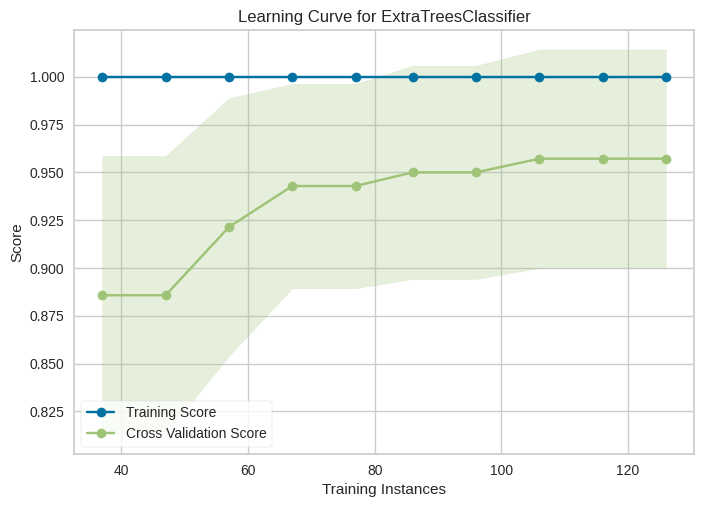

In [ ]:
exp.plot_model(best, plot='learning')

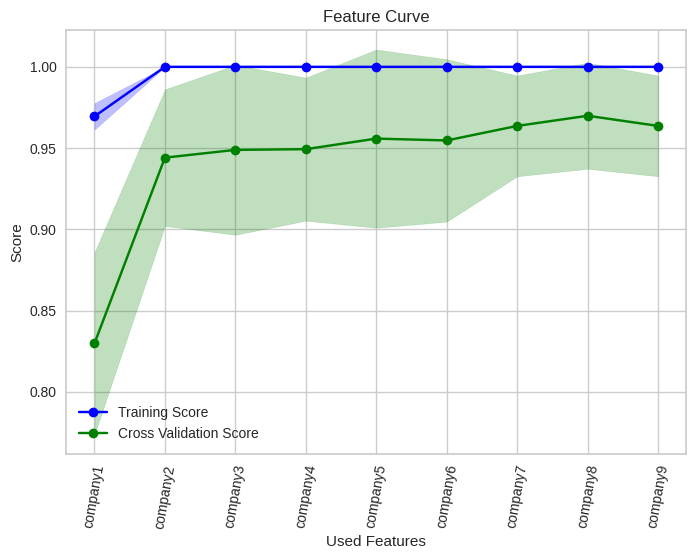

In [ ]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed, features_order=exp.X_train_transformed.columns)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

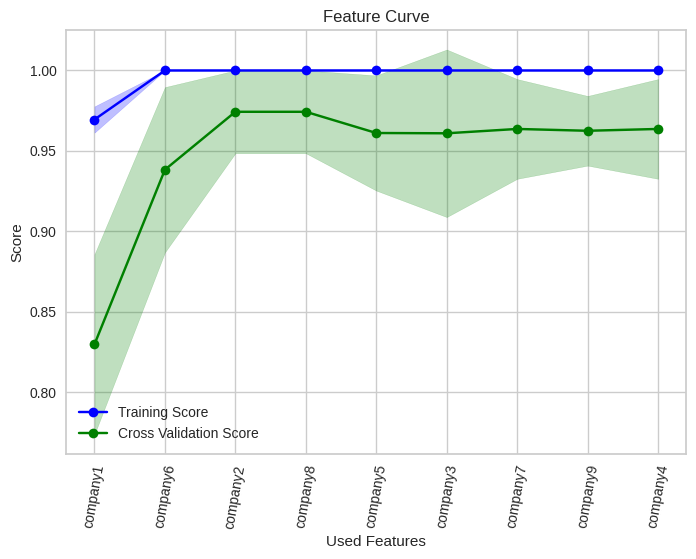

In [ ]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

CPU times: user 6.8 s, sys: 57 ms, total: 6.86 s
Wall time: 6.85 s


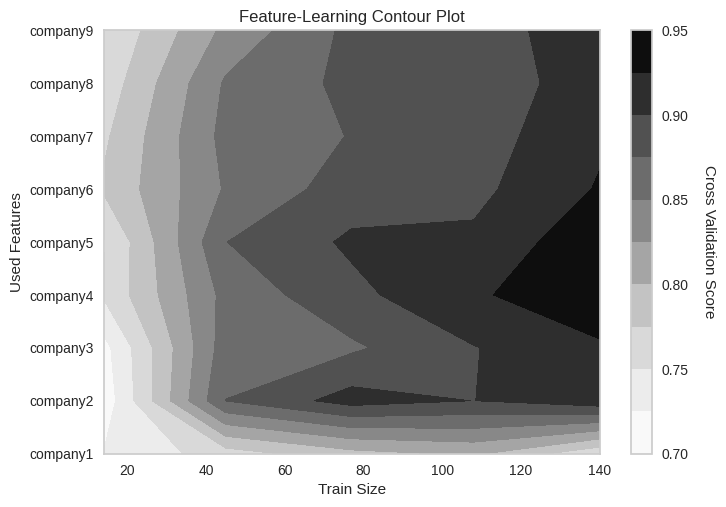

In [ ]:
%%time
flc = FeatureLearningCurve(best, exp.X_train_transformed, exp.y_train_transformed, cv=3,
                           features_order=exp.X_train_transformed.columns, scoring=lambda pred, true: f1_score(pred, true, average='macro')
)
flc.fit(exp.X_train_transformed, exp.y_train_transformed, exp.X_test_transformed, exp.y_test_transformed)

---
### TabEBM with CatBoostEncoder

In [9]:
from tabebm.TabEBM import TabEBM

In [57]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

In [58]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [59]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.936026936026936

In [60]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.9508928571428572